In [6]:
# First, import necessary libraries.
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch
import torch.distributions as dist

from jaxtyping import Float, Int
from torch import Tensor

In [7]:
!wget -nc https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/01_simple_spike_sorting/lab01_data.pt

File ‘lab01_data.pt’ already there; not retrieving.



In [8]:
# Load the data
data = torch.load("lab01_data.pt")
traces = data["traces"]
true_spike_times = data["true_spike_times"]
true_spike_ids = data["true_spike_ids"]
true_templates = data["true_templates"]

# Extract scalar constants 
SAMPLING_FREQUENCY = data["sampling_frequency"]
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = true_spike_times.shape[0]
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape

(array([4.00000e+00, 2.50000e+01, 1.64000e+02, 3.71000e+02, 5.28000e+02,
        4.38000e+02, 4.03000e+02, 4.07000e+02, 4.56000e+02, 1.72200e+03,
        2.47850e+04, 2.54797e+05, 9.92729e+05, 1.41809e+06, 7.46239e+05,
        1.45656e+05, 1.19030e+04, 1.09100e+03, 1.76000e+02, 1.60000e+01]),
 array([-13.52684021, -12.51388836, -11.50093651, -10.48798466,
         -9.47503281,  -8.46208096,  -7.4491291 ,  -6.43617725,
         -5.4232254 ,  -4.41027355,  -3.3973217 ,  -2.38436985,
         -1.371418  ,  -0.35846615,   0.6544857 ,   1.66743755,
          2.6803894 ,   3.6933403 ,   4.70629311,   5.71924591,
          6.73219633]),
 <BarContainer object of 20 artists>)

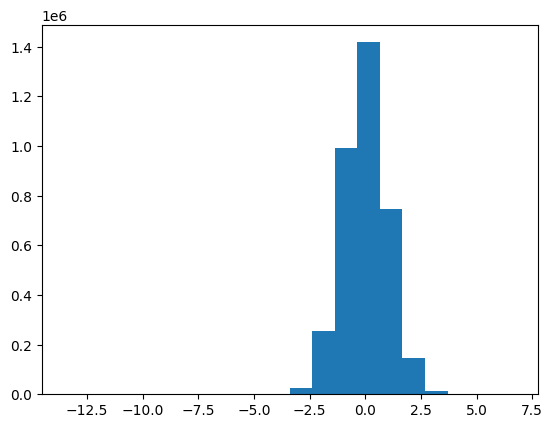

In [19]:
plt.hist(traces[:,0],bins=20)

In [20]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None):
    """
    Plot a slice of the recording and the corresponding spike times.

    Parameters
    ----------
    traces : torch.Tensor
        The voltage traces.
    spike_times : torch.Tensor
        The spike times, in samples.
    spike_ids : torch.Tensor
        The spike IDs, taking values 0,1,2,...,num_neurons-1
    start_time : float
        The start time of the slice, in seconds.
    end_time : float
        The end time of the slice, in seconds.
    ylim : float
        The y-limit for the traces. If None, it is set to 1.05 times the max absolute value of the traces.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1

    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()

    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)

    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")

    # Plot the voltage traces 
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel("trace\n[z-score]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1: 
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs

In [21]:
def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.

    Parameters
    ----------
    waveforms : torch.Tensor
        The waveforms (or templates) to plot.

    name : str
        The name of the waveforms (or templates) to plot. Default is "waveform".
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    fig, axs = plt.subplots(num_channels, num_waveforms, 
                            figsize=(1.25 * num_waveforms, 1.25 * num_channels), 
                            sharex=True, sharey=True)
    lim = 1.05 * waveforms.abs().max()
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            # axs[i,j].set_xlabel("time [samples]")
            # axs[i,j].set_title(f"waveform {j}\n channel {i}")
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [z-score]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    plt.tight_layout()
    
    return fig, axs


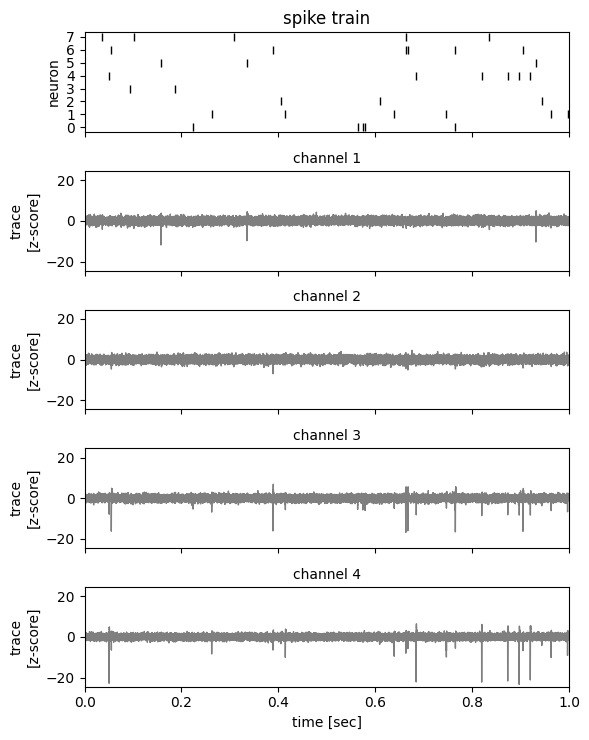

In [22]:
_ = plot_slice(
    traces,
    true_spike_times,
    true_spike_ids,
    start_time=0.0,
    end_time=1.0,
)

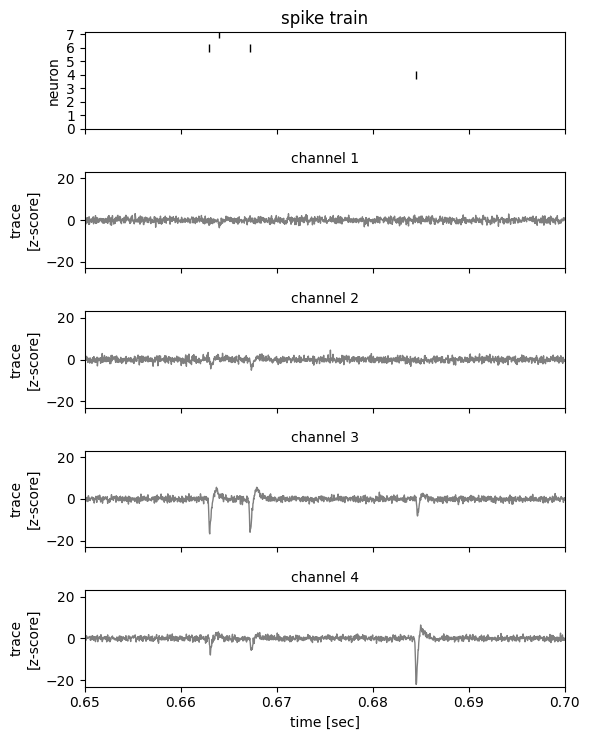

In [23]:
_ = plot_slice(
    traces,
    true_spike_times,
    true_spike_ids,
    start_time=0.65,
    end_time=0.70,
)

Text(0.5, 1.05, 'True templates')

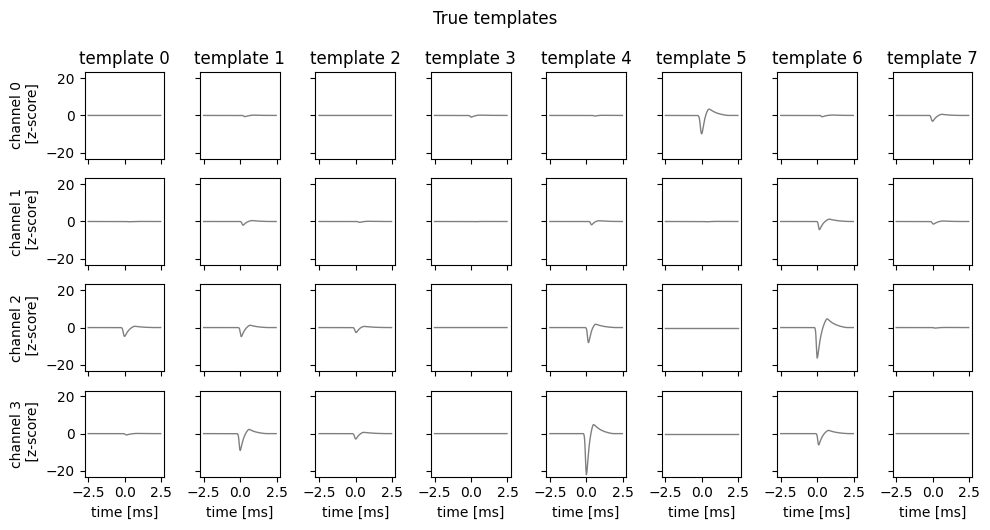

In [24]:
fig, axs = plot_waveforms(true_templates, name="template")
fig.suptitle("True templates", y=1.05)

In [46]:
traces.T@traces

tensor([[3.6133e+06, 1.5064e+04, 6.1057e+03, 2.7904e+03],
        [1.5064e+04, 3.6131e+06, 1.2149e+05, 6.5451e+04],
        [6.1057e+03, 1.2149e+05, 3.6132e+06, 4.7550e+05],
        [2.7904e+03, 6.5451e+04, 4.7550e+05, 3.6132e+06]])

In [47]:
traces

tensor([[ 0.8770,  0.5215, -0.1815,  0.0071],
        [ 0.1546,  0.6982,  2.0720,  0.7538],
        [-0.1168, -0.4079,  1.3060,  0.5789],
        ...,
        [ 0.7008, -0.1540, -0.8441, -0.5124],
        [ 0.9802, -3.0643,  0.6528, -0.7923],
        [ 0.2438, -0.9812, -0.7622, -0.8182]])

In [53]:
min_trace=torch.min(traces,dim=1)[0]

In [54]:
dips=signal.find_peaks(-min_trace, distance=90, height=4)[0]

In [56]:
detected_spike_times = dips

# Make sure the result is a tensor
detected_spike_times = torch.tensor(detected_spike_times)
num_detected_spikes = detected_spike_times.shape[0]

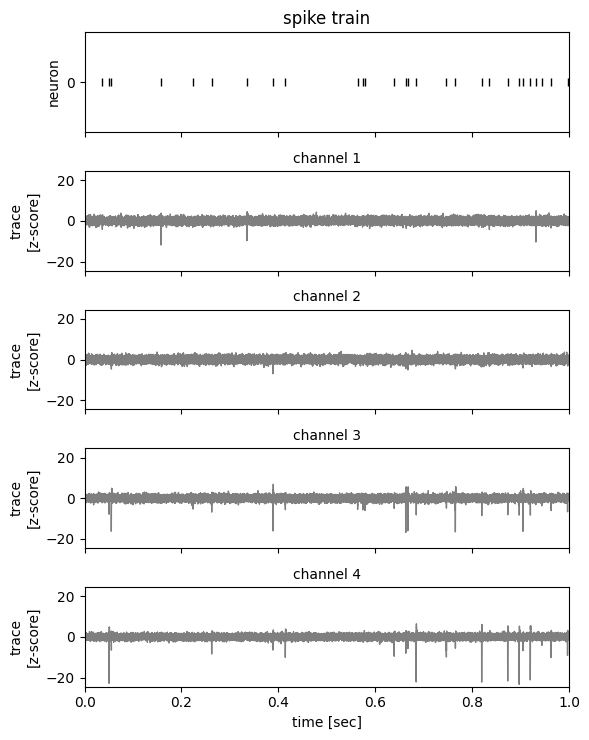

In [57]:
# Plot the inferred spike times with dummy spike ids
dummy_spike_ids = torch.zeros_like(detected_spike_times)

_ = plot_slice(
    traces,
    detected_spike_times,
    dummy_spike_ids,
    start_time=0.,
    end_time=1.0,
)

In [60]:
WINDOW_SIZE

150

In [58]:
spike_waveforms = torch.zeros((num_detected_spikes, WINDOW_SIZE, NUM_CHANNELS))

for i, t in enumerate(detected_spike_times):
    slc = slice(t - WINDOW_SIZE // 2, t + WINDOW_SIZE // 2)
    spike_waveforms[i] = traces[slc]

Text(0.5, 1.05, 'First 5 spike waveforms')

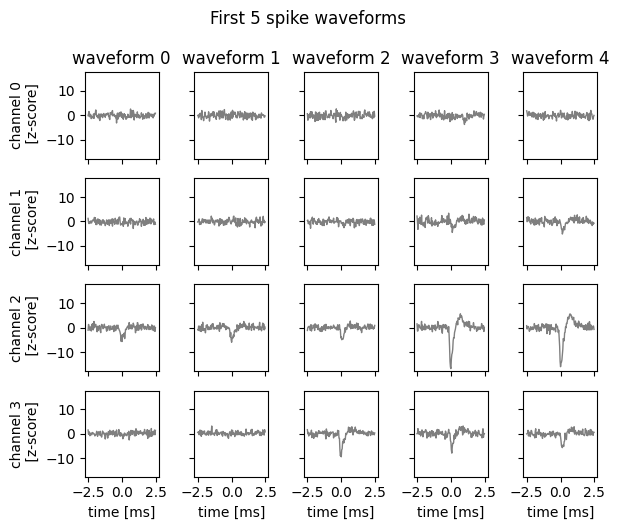

In [61]:
# Plot a few of the waveforms
fig, axs = plot_waveforms(spike_waveforms[10:15], name="waveform")
fig.suptitle("First 5 spike waveforms", y=1.05)


/home/maria/global_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/maria/global_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/maria/global_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


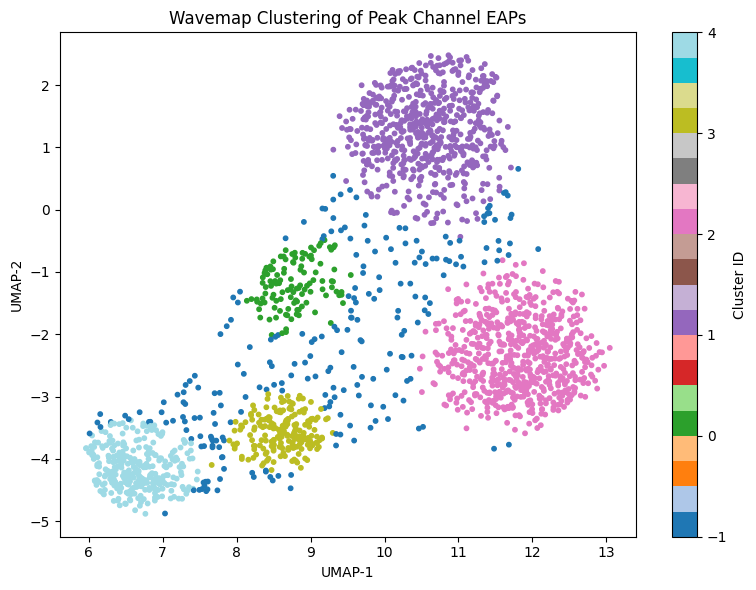

In [64]:
import torch
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt

# --- Step 1: Assume you already have ---
# `spike_waveforms`: shape (N_spikes, T, C)
# Each waveform is (timepoints, channels)
# You want to extract the best channel (peak)

N, T, C = spike_waveforms.shape  # (num_spikes, window_size, num_channels)

# --- Step 2: Get peak channel waveform per spike ---
# For each spike, find the channel with the largest deflection
# (i.e., min value across time and channel)

# Shape: (N, C)
mins = spike_waveforms.min(dim=1).values  # take min over time

# Shape: (N,) -- index of the peak channel for each spike
peak_channels = torch.argmin(mins, dim=1)

# Extract 1D waveform at peak channel for each spike
# Output: (N, T)
peak_waveforms = torch.stack([
    spike_waveforms[i, :, peak_channels[i]] for i in range(N)
])

# Optional: Normalize each waveform to unit norm or z-score
peak_waveforms = (peak_waveforms - peak_waveforms.mean(dim=1, keepdim=True)) / peak_waveforms.std(dim=1, keepdim=True)

# --- Step 3: UMAP embedding ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(peak_waveforms.numpy())  # shape: (N, 2)

# --- Step 4: HDBSCAN clustering ---
clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
labels = clusterer.fit_predict(embedding)

# --- Step 5: Visualization ---
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab20', s=10)
plt.colorbar(label='Cluster ID')
plt.title("Wavemap Clustering of Peak Channel EAPs")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()
